In [32]:
import pandas as pd
import torch

def prepare_cryptocurrency_data(file_path, sequence_size=21, validation_size=150, test_size=30, is_regression=True):
    """
    Cryptocurrency 데이터 준비 함수.
    
    Args:
        file_path (str): 데이터 파일 경로 (CSV 형식).
        sequence_size (int): 시퀀스 크기.
        validation_size (int): 검증 데이터 크기.
        test_size (int): 테스트 데이터 크기.
        is_regression (bool): 회귀 분석 여부. True면 회귀, False면 분류.

    Returns:
        tuple: (X_train, X_val, X_test, y_train, y_val, y_test)
    """
    # 데이터 로드
    df = pd.read_csv(file_path)
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']]  # 필요한 열만 선택

    # 데이터 정규화
    scaler = df.max()  # 열 별 최대값으로 정규화
    df = df / scaler

    # 시퀀스 데이터 생성
    sequences, labels = [], []
    for idx in range(len(df) - sequence_size):
        seq = df.iloc[idx:idx + sequence_size].values
        label = df.iloc[idx + sequence_size]['Close']
        if not is_regression:
            # 분류인 경우: 다음 날의 Close 값이 이전 날보다 크면 1, 아니면 0
            label = 1 if label > df.iloc[idx + sequence_size - 1]['Close'] else 0
        sequences.append(seq)
        labels.append(label)

    # numpy 배열로 변환
    sequences = torch.tensor(sequences, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.float32 if is_regression else torch.int64)

    # 데이터 분리
    train_size = len(sequences) - validation_size - test_size
    X_train, y_train = sequences[:train_size], labels[:train_size]
    X_val, y_val = sequences[train_size:train_size + validation_size], labels[train_size:train_size + validation_size]
    X_test, y_test = sequences[train_size + validation_size:], labels[train_size + validation_size:]

    return X_train, X_val, X_test, y_train, y_val, y_test

# 테스트
if __name__ == "__main__":
    # 파일 경로 설정
    file_path = "./BTC_KRW.csv"

    # Regression 데이터 준비
    print("Preparing regression data...")
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_cryptocurrency_data(
        file_path, sequence_size=21, validation_size=150, test_size=30, is_regression=True
    )
    print(f"Regression: Train shape: {X_train.shape}, Validation shape: {X_val.shape}, Test shape: {X_test.shape}")

    # Classification 데이터 준비
    print("\nPreparing classification data...")
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_cryptocurrency_data(
        file_path, sequence_size=21, validation_size=150, test_size=30, is_regression=False
    )
    print(f"Classification: Train shape: {X_train.shape}, Validation shape: {X_val.shape}, Test shape: {X_test.shape}")


Preparing regression data...
Regression: Train shape: torch.Size([3527, 21, 5]), Validation shape: torch.Size([150, 21, 5]), Test shape: torch.Size([30, 21, 5])

Preparing classification data...
Classification: Train shape: torch.Size([3527, 21, 5]), Validation shape: torch.Size([150, 21, 5]), Test shape: torch.Size([30, 21, 5])


In [33]:
#15f-argparser

In [34]:
import argparse


def get_parser():
    parser = argparse.ArgumentParser()

    parser.add_argument(
    "--wandb", action=argparse.BooleanOptionalAction, default=False, help="True or False"
    )

    parser.add_argument(
    "-b", "--batch_size", type=int, default=2048, help="Batch size (int, default: 2_048)"
    )

    parser.add_argument(
    "-e", "--epochs", type=int, default=10_000, help="Number of training epochs (int, default:10_000)"
    )

    parser.add_argument(
    "-r", "--learning_rate", type=float, default=1e-4, help="Learning rate (float, default: 1e-3)"
    )

    parser.add_argument(
    "-w", "--weight_decay", type=float, default=0.0, help="Weight decay (float, default: 0.0)"
    )

    parser.add_argument(
    "-v", "--validation_intervals", type=int, default=30,
    help="Number of training epochs between validations (int, default: 10)"
    )

    parser.add_argument(
    "-p", "--early_stop_patience", type=int, default=30,
    help="Number of early stop patience (int, default: 10)"
    )

    parser.add_argument(
    "-d", "--early_stop_delta", type=float, default=0.000001,
    help="Delta value of early stop (float, default: 0.000001)"
    )

    return parser


In [35]:
#8c-earlystopping

In [36]:
import os
import torch


class EarlyStopping:
    """Validation Loss가 개선되지 않으면 학습을 조기에 중단하는 클래스."""
    def __init__(self, patience=10, delta=0.00001, project_name=None, checkpoint_file_path=None, run_time_str=None):
        """
        초기화 메서드.
        Args:
            patience (int): 개선되지 않을 때 기다릴 에폭 수.
            delta (float): Loss 감소 최소값.
            project_name (str): 프로젝트 이름 (체크포인트 파일명에 사용).
            checkpoint_file_path (str): 체크포인트 저장 경로.
            run_time_str (str): 체크포인트 파일명에 사용할 고유 문자열.
        """
        self.patience = patience  # 개선되지 않을 때 기다릴 최대 에폭 수
        self.counter = 0  # 개선되지 않은 에폭 수를 추적
        self.delta = delta  # 개선으로 간주되는 최소 Loss 감소값
        self.val_loss_min = None  # 현재까지의 최소 Validation Loss 저장
        self.file_path = os.path.join(
            checkpoint_file_path, f"{project_name}_checkpoint_{run_time_str}.pt"
        )  # 체크포인트 저장 경로
        self.latest_file_path = os.path.join(
            checkpoint_file_path, f"{project_name}_checkpoint_latest.pt"
        )  # 최신 체크포인트 저장 경로

    def check_and_save(self, new_validation_loss, model):
        """
        Validation Loss를 확인하고 필요 시 모델 저장.
        Args:
            new_validation_loss (float): 현재 에폭의 Validation Loss.
            model (torch.nn.Module): 저장할 PyTorch 모델.
        Returns:
            message (str): 현재 상태 메시지.
            early_stop (bool): 조기 종료 여부.
        """
        early_stop = False

        if self.val_loss_min is None:
            # 최초 Validation Loss 설정
            self.val_loss_min = new_validation_loss
            message = f'Early stopping is stated!'
        elif new_validation_loss < self.val_loss_min - self.delta:
            # Validation Loss가 개선된 경우
            message = f'V_loss decreased ({self.val_loss_min:7.5f} --> {new_validation_loss:7.5f}). Saving model...'
            self.save_checkpoint(new_validation_loss, model)
            self.val_loss_min = new_validation_loss  # 최소 Loss 업데이트
            self.counter = 0  # Counter 초기화
        else:
            # 개선되지 않은 경우 Counter 증가
            self.counter += 1
            message = f'Early stopping counter: {self.counter} out of {self.patience}'
            if self.counter >= self.patience:
                early_stop = True  # Patience 초과 시 조기 종료
                message += " *** TRAIN EARLY STOPPED! ***"

        return message, early_stop

    def save_checkpoint(self, val_loss, model):
        """
        Validation Loss 개선 시 모델 저장.
        Args:
            val_loss (float): 현재 Validation Loss.
            model (torch.nn.Module): 저장할 PyTorch 모델.
        """
        torch.save(model.state_dict(), self.file_path)  # 지정된 파일명으로 모델 저장
        torch.save(model.state_dict(), self.latest_file_path)  # 최신 파일명으로 모델 저장
        self.val_loss_min = val_loss  # 최소 Loss 업데이트

In [37]:
#99common-strfdelta

In [38]:
import os
import sys


# 운영체제 확인 함수
def is_linux():
    return sys.platform.startswith("linux")

def is_windows():
    return os.name == "nt"

def is_mac():
    return sys.platform == "darwin"

# CPU 코어 수 확인 함수
def get_num_cpu_cores():
    import multiprocessing
    return multiprocessing.cpu_count()

# timedelta 형식 변환 클래스 및 함수
class DeltaTemplate(Template):
    delimiter = "%"

def strfdelta(td, fmt):
    sign = "-" if td.days < 0 else "+"  # 음수일 경우 '-' 추가
    secs = abs(td).total_seconds()  # 절대값으로 초 계산
    days, rem = divmod(secs, 86400)  # 초를 일, 시간, 분으로 분리
    hours, rem = divmod(rem, 3600)
    mins, secs = divmod(rem, 60)
    t = DeltaTemplate(fmt)
    return t.substitute(
        s=sign,
        D="{:d}".format(int(days)),
        H="{:02d}".format(int(hours)),
        M="{:02d}".format(int(mins)),
        S="{:02d}".format(int(secs)),
    )

def strfdelta(td, fmt):

    # Get the timedelta’s sign and absolute number of seconds.
    sign = "-" if td.days < 0 else "+"
    secs = abs(td).total_seconds()

    # Break the seconds into more readable quantities.
    days, rem = divmod(secs, 86400)  # Seconds per day: 24 * 60 * 60
    hours, rem = divmod(rem, 3600)  # Seconds per hour: 60 * 60
    mins, secs = divmod(rem, 60)

    # Format (as per above answers) and return the result string.
    t = DeltaTemplate(fmt)
    return t.substitute(
        s=sign,
        D="{:d}".format(int(days)),
        H="{:02d}".format(int(hours)),
        M="{:02d}".format(int(mins)),
        S="{:02d}".format(int(secs)),
        )


if __name__ == "__main__":
    if is_linux():
        print("Linux")
    elif is_windows():
        print("Windows")
    elif is_mac():
        print("Mac")
    else:
        print("<unknown>")


Linux


In [39]:
#14g-rnntrainer

In [40]:
from datetime import datetime
import torch
from torch import nn

# RegressionTrainer 클래스
class RegressionTrainer:
    def __init__(
        self, project_name, model, optimizer, train_data_loader, validation_data_loader, transforms,
        run_time_str, wandb, device, checkpoint_file_path
    ):
        self.project_name = project_name
        self.model = model
        self.optimizer = optimizer
        self.train_data_loader = train_data_loader
        self.validation_data_loader = validation_data_loader
        self.transforms = transforms
        self.run_time_str = run_time_str
        self.wandb = wandb
        self.device = device
        self.checkpoint_file_path = checkpoint_file_path

        # Use a built-in loss function
        self.loss_fn = nn.MSELoss()

    def do_train(self):
        self.model.train()  # Set the model to training mode

        loss_train = 0.0
        num_trains = 0

        for train_batch in self.train_data_loader:
            input_train, target_train = train_batch
            input_train = input_train.to(device=self.device)
            target_train = target_train.to(device=self.device)

            if self.transforms:
                input_train = self.transforms(input_train)

            output_train = self.model(input_train)

            loss = self.loss_fn(output_train.squeeze(dim=-1), target_train)

            loss_train += loss.item()
            num_trains += 1

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        train_loss = loss_train / num_trains
        return train_loss

    def do_validation(self):
        self.model.eval()  # Set the model to evaluation mode

        loss_validation = 0.0
        num_validations = 0

        with torch.no_grad():
            for validation_batch in self.validation_data_loader:
                input_validation, target_validation = validation_batch
                input_validation = input_validation.to(device=self.device)
                target_validation = target_validation.to(device=self.device)

                if self.transforms:
                    input_validation = self.transforms(input_validation)

                output_validation = self.model(input_validation)

                loss_validation += self.loss_fn(output_validation.squeeze(dim=-1), target_validation).item()
                num_validations += 1

        validation_loss = loss_validation / num_validations
        return validation_loss

    def train_loop(self):
        early_stopping = EarlyStopping(
            patience=self.wandb.config.early_stop_patience,
            delta=self.wandb.config.early_stop_delta,
            project_name=self.project_name,
            checkpoint_file_path=self.checkpoint_file_path,
            run_time_str=self.run_time_str
        )
        n_epochs = self.wandb.config.epochs
        training_start_time = datetime.now()

        for epoch in range(1, n_epochs + 1):
            train_loss = self.do_train()

            if epoch == 1 or epoch % self.wandb.config.validation_intervals == 0:
                validation_loss = self.do_validation()

                elapsed_time = datetime.now() - training_start_time
                epoch_per_second = 1000 * epoch / elapsed_time.microseconds

                message, early_stop = early_stopping.check_and_save(validation_loss, self.model)

                print(
                    f"[Epoch {epoch:>3}] "
                    f"T_loss: {train_loss:7.5f}, "
                    f"V_loss: {validation_loss:7.5f}, "
                    f"{message} | "
                    f"T_time: {strfdelta(elapsed_time, '%H:%M:%S')}, "
                    f"T_speed: {epoch_per_second:4.3f}"
                )

                self.wandb.log({
                    "Epoch": epoch,
                    "Training loss": train_loss,
                    "Validation loss": validation_loss,
                    "Training speed (epochs/sec.)": epoch_per_second,
                })

                if early_stop:
                    break

        elapsed_time = datetime.now() - training_start_time
        print(f"Final training time: {strfdelta(elapsed_time, '%H:%M:%S')}")


In [41]:
#14p

In [42]:
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import os
import torch
import pandas as pd
import numpy as np

# BASE_PATH 수정: 현재 디렉토리를 기준으로 설정
BASE_PATH = str(Path(os.getcwd()))  # Jupyter Notebook에서 동작하도록 수정
import sys
sys.path.append(BASE_PATH)

# CryptoCurrencyDataset 클래스
class CryptoCurrencyDataset(Dataset):
    def __init__(self, X, y, is_regression=True):
        self.X = X
        self.y = y

        assert len(self.X) == len(self.y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]
        return X, y

    def __str__(self):
        return "Data Size: {0}, Input Shape: {1}, Target Shape: {2}".format(
            len(self.X), self.X.shape, self.y.shape
        )

# 데이터 로드 및 정규화 함수
def get_cryptocurrency_data(
    sequence_size=10, validation_size=100, test_size=10, target_column='Close', y_normalizer=1.0e7, is_regression=True
):
    btc_krw_path = "./BTC_KRW.csv"
    df = pd.read_csv(btc_krw_path)
    row_size = len(df)
    # ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
    date_list = df['Date']

    df = df.drop(columns=['Date'])

    data_size = row_size - sequence_size
    # Train, Validation, Test 데이터 분리
    train_size = data_size - (validation_size + test_size)

    row_cursor = 0

    # Train data
    X_train_list = []
    y_train_regression_list = []
    y_train_classification_list = []
    y_train_date = []
    for idx in range(0, train_size):
        sequence_data = df.iloc[idx: idx + sequence_size].values
        X_train_list.append(torch.from_numpy(sequence_data))
        y_train_regression_list.append(df.iloc[idx + sequence_size][target_column])
        y_train_classification_list.append(
            1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
        )
        y_train_date.append(date_list[idx + sequence_size])
        row_cursor += 1

    X_train = torch.stack(X_train_list, dim=0).to(torch.float)
    y_train_regression = torch.tensor(y_train_regression_list, dtype=torch.float32) / y_normalizer
    y_train_classification = torch.tensor(y_train_classification_list, dtype=torch.int64)

    m = X_train.mean(dim=0, keepdim=True)
    s = X_train.std(dim=0, keepdim=True)
    X_train = (X_train - m) / s

    # Validation data
    X_validation_list = []
    y_validation_regression_list = []
    y_validation_classification_list = []
    y_validation_date = []
    for idx in range(row_cursor, row_cursor + validation_size):
        sequence_data = df.iloc[idx: idx + sequence_size].values
        X_validation_list.append(torch.from_numpy(sequence_data))
        y_validation_regression_list.append(df.iloc[idx + sequence_size][target_column])
        y_validation_classification_list.append(
            1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
        )
        y_validation_date.append(date_list[idx + sequence_size])
        row_cursor += 1

    X_validation = torch.stack(X_validation_list, dim=0).to(torch.float)
    y_validation_regression = torch.tensor(y_validation_regression_list, dtype=torch.float32) / y_normalizer
    y_validation_classification = torch.tensor(y_validation_classification_list, dtype=torch.int64)

    X_validation = (X_validation - m) / s

    # Test data
    X_test_list = []
    y_test_regression_list = []
    y_test_classification_list = []
    y_test_date = []
    for idx in range(row_cursor, row_cursor + test_size):
        sequence_data = df.iloc[idx: idx + sequence_size].values
        X_test_list.append(torch.from_numpy(sequence_data))
        y_test_regression_list.append(df.iloc[idx + sequence_size][target_column])
        y_test_classification_list.append(
            1 if df.iloc[idx + sequence_size][target_column] > df.iloc[idx + sequence_size - 1][target_column] else 0
        )
        y_test_date.append(date_list[idx + sequence_size])
        row_cursor += 1

    X_test = torch.stack(X_test_list, dim=0).to(torch.float)
    y_test_regression = torch.tensor(y_test_regression_list, dtype=torch.float32) / y_normalizer
    y_test_classification = torch.tensor(y_test_classification_list, dtype=torch.int64)

    X_test = (X_test - m) / s

    if is_regression:
        return (
            X_train, X_validation, X_test,
            y_train_regression, y_validation_regression, y_test_regression,
            y_train_date, y_validation_date, y_test_date
        )
    else:
        return (
            X_train, X_validation, X_test,
            y_train_classification, y_validation_classification, y_test_classification,
            y_train_date, y_validation_date, y_test_date
        )


if __name__ == "__main__":
    is_regression = False

    X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
        = get_cryptocurrency_data(
        sequence_size=10, validation_size=100, test_size=10,
        target_column='Close', y_normalizer=1.0e7, is_regression=is_regression
    )

    train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train, is_regression=is_regression)
    validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation, is_regression=is_regression)
    test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test, is_regression=is_regression)

    train_data_loader = DataLoader(
        dataset=train_crypto_currency_dataset,
        batch_size=32,
        shuffle=True,
        drop_last=True
    )

    for idx, batch in enumerate(train_data_loader):
        input, target = batch
        print("{0} - {1}: {2}, {3}".format(idx, input.shape, target.shape, target))


0 - torch.Size([32, 10, 5]): torch.Size([32]), tensor([0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
        0, 1, 1, 0, 1, 0, 1, 1])
1 - torch.Size([32, 10, 5]): torch.Size([32]), tensor([0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        1, 1, 1, 1, 0, 0, 1, 1])
2 - torch.Size([32, 10, 5]): torch.Size([32]), tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
        1, 1, 1, 1, 1, 1, 0, 0])
3 - torch.Size([32, 10, 5]): torch.Size([32]), tensor([0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0,
        0, 1, 1, 0, 0, 1, 1, 1])
4 - torch.Size([32, 10, 5]): torch.Size([32]), tensor([0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 1, 1, 0, 1, 1, 1])
5 - torch.Size([32, 10, 5]): torch.Size([32]), tensor([0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
        0, 1, 0, 0, 0, 0, 0, 1])
6 - torch.Size([32, 10, 5]): torch.Size(

In [43]:
#08c-trainer

In [44]:
from datetime import datetime
import torch
from torch import nn

# ClassificationTrainer 클래스
class ClassificationTrainer:
    def __init__(
        self, project_name, model, optimizer, train_data_loader, validation_data_loader, transforms,
        run_time_str, wandb, device, checkpoint_file_path
    ):
        self.project_name = project_name
        self.model = model
        self.optimizer = optimizer
        self.train_data_loader = train_data_loader
        self.validation_data_loader = validation_data_loader
        self.transforms = transforms
        self.run_time_str = run_time_str
        self.wandb = wandb
        self.device = device
        self.checkpoint_file_path = checkpoint_file_path

        # 분류 모델의 손실 함수
        self.loss_fn = nn.CrossEntropyLoss()

    # 학습 단계
    def do_train(self):
        self.model.train()

        loss_train = 0.0
        num_corrects_train = 0
        num_trained_samples = 0
        num_trains = 0

        for train_batch in self.train_data_loader:
            input_train, target_train = train_batch
            input_train = input_train.to(device=self.device)
            target_train = target_train.to(device=self.device)

            if self.transforms:
                input_train = self.transforms(input_train)

            output_train = self.model(input_train)
            loss = self.loss_fn(output_train, target_train)
            loss_train += loss.item()

            # 정확도 계산
            predicted_train = torch.argmax(output_train, dim=-1)
            num_corrects_train += torch.sum(torch.eq(predicted_train, target_train)).item()
            num_trained_samples += len(input_train)
            num_trains += 1

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        train_loss = loss_train / num_trains
        train_accuracy = 100.0 * num_corrects_train / num_trained_samples

        return train_loss, train_accuracy

    # 검증 단계
    def do_validation(self):
        self.model.eval()

        loss_validation = 0.0
        num_corrects_validation = 0
        num_validated_samples = 0
        num_validations = 0

        with torch.no_grad():
            for validation_batch in self.validation_data_loader:
                input_validation, target_validation = validation_batch
                input_validation = input_validation.to(device=self.device)
                target_validation = target_validation.to(device=self.device)

                if self.transforms:
                    input_validation = self.transforms(input_validation)

                output_validation = self.model(input_validation)
                loss_validation += self.loss_fn(output_validation, target_validation).item()

                # 정확도 계산
                predicted_validation = torch.argmax(output_validation, dim=1)
                num_corrects_validation += torch.sum(torch.eq(predicted_validation, target_validation)).item()
                num_validated_samples += len(input_validation)
                num_validations += 1

        validation_loss = loss_validation / num_validations
        validation_accuracy = 100.0 * num_corrects_validation / num_validated_samples

        return validation_loss, validation_accuracy

    # 학습 루프
    def train_loop(self):
        early_stopping = EarlyStopping(
            patience=self.wandb.config.early_stop_patience,
            delta=self.wandb.config.early_stop_delta,
            project_name=self.project_name,
            checkpoint_file_path=self.checkpoint_file_path,
            run_time_str=self.run_time_str
        )
        n_epochs = self.wandb.config.epochs
        training_start_time = datetime.now()

        for epoch in range(1, n_epochs + 1):
            train_loss, train_accuracy = self.do_train()

            if epoch == 1 or epoch % self.wandb.config.validation_intervals == 0:
                validation_loss, validation_accuracy = self.do_validation()

                elapsed_time = datetime.now() - training_start_time
                epoch_per_second = 0 if elapsed_time.seconds == 0 else epoch / elapsed_time.seconds

                message, early_stop = early_stopping.check_and_save(validation_loss, self.model)

                print(
                    f"[Epoch {epoch:>3}] "
                    f"T_loss: {train_loss:7.5f}, "
                    f"T_accuracy: {train_accuracy:6.4f} | "
                    f"V_loss: {validation_loss:7.5f}, "
                    f"V_accuracy: {validation_accuracy:6.4f} | "
                    f"{message} | "
                    f"T_time: {strfdelta(elapsed_time, '%H:%M:%S')}, "
                    f"T_speed: {epoch_per_second:4.3f}"
                )

                # wandb 로그 저장
                self.wandb.log({
                    "Epoch": epoch,
                    "Training loss": train_loss,
                    "Training accuracy (%)": train_accuracy,
                    "Validation loss": validation_loss,
                    "Validation accuracy (%)": validation_accuracy,
                    "Training speed (epochs/sec.)": epoch_per_second,
                })

                if early_stop:
                    break

        elapsed_time = datetime.now() - training_start_time
        print(f"Final training time: {strfdelta(elapsed_time, '%H:%M:%S')}")


In [45]:
#15g

In [46]:
!pip install wandb
import wandb

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
DEPRECATION: devscripts 2.22.1ubuntu1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of devscripts or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip


In [47]:
wandb.login(relogin=True)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ········


wandb: Appending key for api.wandb.ai to your netrc file: /home/work/.netrc


True

In [48]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from datetime import datetime
import os
import wandb
from pathlib import Path

BASE_PATH = os.getcwd()  # 현재 작업 디렉터리를 BASE_PATH로 설정
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = BASE_PATH
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
    os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

# BTC-KRW 데이터 로드 및 DataLoader 생성
def get_btc_krw_data(sequence_size=10, validation_size=100, test_size=10, is_regression=True):
    X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date = get_cryptocurrency_data(
        sequence_size=sequence_size, validation_size=validation_size, test_size=test_size,
        target_column='Close', y_normalizer=1.0e7, is_regression=is_regression
    )

    # Dataset 및 DataLoader 생성
    train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
    validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
    test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

    train_data_loader = DataLoader(
        dataset=train_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
    )
    validation_data_loader = DataLoader(
        dataset=validation_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
    )
    test_data_loader = DataLoader(
        dataset=test_crypto_currency_dataset, batch_size=len(test_crypto_currency_dataset), shuffle=True
    )

    return train_data_loader, validation_data_loader, test_data_loader

# LSTM 기반 모델 정의
def get_model():
    class MyModel(nn.Module):
        def __init__(self, n_input, n_output):
            super().__init__()
            self.lstm = nn.LSTM(input_size=n_input, hidden_size=128, num_layers=2, batch_first=True)
            self.fcn = nn.Linear(in_features=128, out_features=n_output)

        def forward(self, x):
            x, hidden = self.lstm(x)
            x = x[:, -1, :] # 마지막 타임스텝의 출력만 사용
            x = self.fcn(x)
            return x

    return MyModel(n_input=5, n_output=1)

# 메인 함수
def main():
    # 기본 설정 값
    class Args:
        wandb = True
        batch_size = 32
        epochs = 10_000  
        learning_rate = 1e-4  
        validation_intervals = 10  
        early_stop_patience = 10 
        early_stop_delta = 0.00001
        weight_decay = 0.01

    args = Args()

    # 실행 시간 문자열 생성
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    # Config 설정
    config = {
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'validation_intervals': args.validation_intervals,
        'learning_rate': args.learning_rate,
        'early_stop_patience': args.early_stop_patience,
        'early_stop_delta': args.early_stop_delta,
        'weight_decay': args.weight_decay,
    }

    # Wandb 초기화
    wandb.init(
        mode="online" if args.wandb else "disabled",
        project="btc-krw-15g",
        notes="btc_krw experiment with lstm",
        tags=["lstm", "regression", "btc_krw"],
        name=run_time_str,
        config=config,
    )
    
    if 'early_stop_patience' not in wandb.config:
        wandb.config.update({'early_stop_patience': args.early_stop_patience})
        
    if 'validation_intervals' not in wandb.config:
        wandb.config.update({'validation_intervals': 10})  # 기본값 10 설정
    
    if 'early_stop_delta' not in wandb.config:
        wandb.config.update({'early_stop_delta': args.early_stop_delta})
        
    if 'weight_decay' not in wandb.config:
        print("Setting default weight_decay in wandb.config.")
        wandb.config.update({'weight_decay': args.weight_decay})

    print("Updated Wandb Config Contents:", dict(wandb.config))  # 업데이트된 Config 

    train_data_loader, validation_data_loader, _ = get_btc_krw_data()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training on device {device}.")

    model = get_model()
    model.to(device)

    # 옵티마이저 설정
    optimizer = optim.Adam(
        model.parameters(),
        lr=wandb.config.learning_rate,
        weight_decay=wandb.config.weight_decay
    )

    # RegressionTrainer 초기화 및 학습 루프 시작
    regression_trainer = RegressionTrainer(
        "btc-krw", model, optimizer, train_data_loader, validation_data_loader, None,
        run_time_str, wandb, device, CHECKPOINT_FILE_PATH
    )
    regression_trainer.train_loop()

    # Wandb 종료
    wandb.finish()


if __name__ == "__main__":
    main()

    # python _01_code/_11_lstm_and_its_application/f_crypto_currency_regression_train_lstm.py --wandb

wandb: Currently logged in as: seongjae6751 (seongjae6751-koreatech). Use `wandb login --relogin` to force relogin
/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Updated Wandb Config Contents: {'epochs': 10000, 'batch_size': 32, 'validation_intervals': 10, 'learning_rate': 0.0001, 'early_stop_patience': 10, 'early_stop_delta': 1e-05, 'weight_decay': 0.01}
Training on device cuda:0.
[Epoch   1] T_loss: 6.70293, V_loss: 16.44431, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.002
[Epoch  10] T_loss: 0.05942, V_loss: 1.21820, V_loss decreased (16.44431 --> 1.21820). Saving model... | T_time: 00:00:04, T_speed: 0.260
[Epoch  20] T_loss: 0.04938, V_loss: 1.37994, Early stopping counter: 1 out of 10 | T_time: 00:00:07, T_speed: 0.023
[Epoch  30] T_loss: 0.04383, V_loss: 0.85006, V_loss decreased (1.21820 --> 0.85006). Saving model... | T_time: 00:00:11, T_speed: 0.041
[Epoch  40] T_loss: 0.04180, V_loss: 1.02797, Early stopping counter: 1 out of 10 | T_time: 00:00:15, T_speed: 0.067
[Epoch  50] T_loss: 0.03796, V_loss: 0.66306, V_loss decreased (0.85006 --> 0.66306). Saving model... | T_time: 00:00:19, T_speed: 0.107
[Epoch  60] T_loss: 0.0

Epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
Training loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▂▁▁▁▁▁▁▄▁▁▁▁▁▁▂█▁
Validation loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,320
Training loss,0.03068
Training speed (epochs/sec.),0.3653
Validation loss,0.63495


In [49]:
#15h

usage: ipykernel_launcher.py [-h] [--wandb | --no-wandb] [-b BATCH_SIZE]
                             [-e EPOCHS] [-r LEARNING_RATE] [-w WEIGHT_DECAY]
                             [-v VALIDATION_INTERVALS]
                             [-p EARLY_STOP_PATIENCE] [-d EARLY_STOP_DELTA]
ipykernel_launcher.py: error: unrecognized arguments: -f /home/work/.local/share/jupyter/runtime/kernel-bb8ba76a-918f-4d4a-8156-a1aa1727886e.json


MODEL FILE: /home/work/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt
[TEST DATA]
 0: 1,128.30 <--> 1,331.62 (Loss:        203.32)
 1: 1,130.64 <--> 1,378.05 (Loss:        247.41)
 2: 1,123.65 <--> 1,373.29 (Loss:        249.64)
 3: 1,101.30 <--> 1,319.45 (Loss:        218.14)
 4: 1,114.48 <--> 1,390.43 (Loss:        275.95)
 5: 1,134.36 <--> 1,284.38 (Loss:        150.02)
 6: 1,129.18 <--> 1,360.09 (Loss:        230.92)
 7: 1,106.84 <--> 1,380.87 (Loss:        274.03)
 8: 1,129.67 <--> 1,334.58 (Loss:        204.91)
 9: 1,134.96 <--> 1,302.60 (Loss:        167.64)


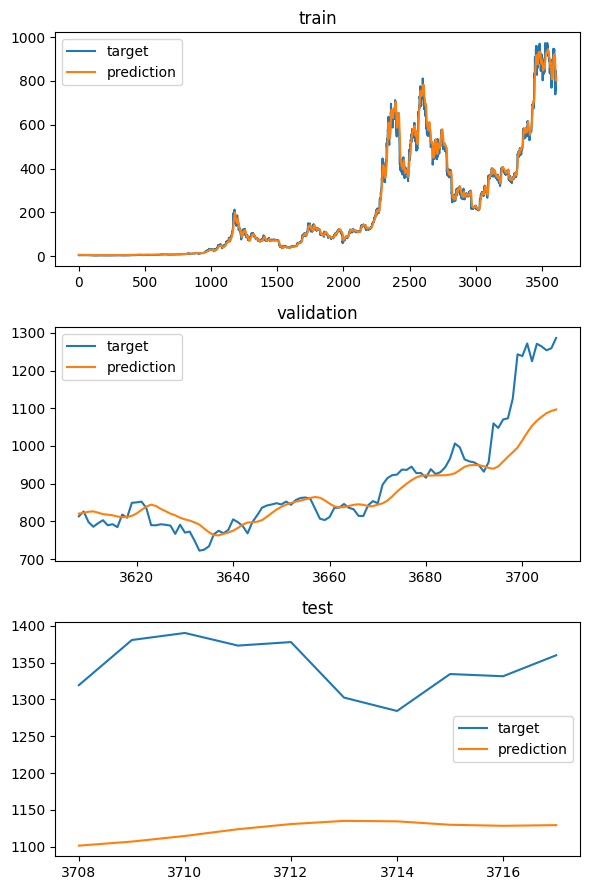

In [50]:
import torch
import wandb
from matplotlib import pyplot as plt
from datetime import datetime
import os
from pathlib import Path

BASE_PATH = os.getcwd()  # 현재 작업 디렉터리를 BASE_PATH로 설정
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = BASE_PATH
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
    os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

# 테스트 함수
def test(test_model):
    _, _, test_data_loader = get_btc_krw_data()

    test_model.eval()

    y_normalizer = 100

    print("[TEST DATA]")
    with torch.no_grad():
        for test_batch in test_data_loader:
            input_test, target_test = test_batch

            output_test = test_model(input_test)

        # 예측값과 실제값 출력
        for idx, (output, target) in enumerate(zip(output_test, target_test)):
            print("{0:2}: {1:6,.2f} <--> {2:6,.2f} (Loss: {3:>13,.2f})".format(
                idx,
                output.item() * y_normalizer,
                target.item() * y_normalizer,
                abs(output.squeeze(dim=-1).item() - target.item()) * y_normalizer
            ))

# 전체 데이터셋에 대해 예측 및 시각화
def predict_all(test_model):
    y_normalizer = 100

    X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
        = get_cryptocurrency_data(
            sequence_size=10, validation_size=100, test_size=10,
            target_column='Close', y_normalizer=1.0e7, is_regression=True
    )

    train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
    validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
    test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

    # 데이터셋 및 라벨 설정
    dataset_list = [
        train_crypto_currency_dataset, validation_crypto_currency_dataset, test_crypto_currency_dataset
    ]
    dataset_labels = [
        "train", "validation", "test"
    ]
    num = 0
    
    # 시각화
    fig, axs = plt.subplots(3, 1, figsize=(6, 9))

    for i in range(3):
        X = []
        TARGET_Y = []
        PREDICTION_Y = []
        for data in dataset_list[i]:
            input, target = data
            prediction = test_model(input.unsqueeze(0)).squeeze(-1).squeeze(-1)

            X.append(num)
            TARGET_Y.append(target.item() * y_normalizer)
            PREDICTION_Y.append(prediction.item() * y_normalizer)

            num += 1

        axs[i].plot(X, TARGET_Y, label='target')
        axs[i].plot(X, PREDICTION_Y, label='prediction')
        axs[i].set_title(dataset_labels[i])
        axs[i].legend()

    plt.tight_layout()
    plt.show()


def main(args):
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    config = {
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'validation_intervals': args.validation_intervals,
        'learning_rate': args.learning_rate,
        'early_stop_patience': args.early_stop_patience,
        'early_stop_delta': args.early_stop_delta,
    }

    project_name = "lstm_regression_btc_krw"
    wandb.init(
        mode="disabled",
        project=project_name,
        notes="btc_krw experiment with lstm",
        tags=["lstm", "regression", "btc_krw"],
        name=run_time_str,
        config=config
    )

    # 모델 초기화 및 체크포인트 로드
    test_model = get_model()

    project_name = "lstm_regression_btc_krw"
    latest_file_path = os.path.join(
        CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
    )
    print("MODEL FILE: {0}".format(latest_file_path))
    test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

    test(test_model)
    predict_all(test_model)


if __name__ == "__main__":
    try:
        # Jupyter 환경이 아닌 경우 argparse 사용
        parser = get_parser()
        args = parser.parse_args()
    except:
        # Jupyter Notebook 환경에서 argparse 대체
        class Args:
            wandb = False
            batch_size = 32
            epochs = 10_000
            learning_rate = 1e-4
            weight_decay = 0.01
            validation_intervals = 10
            early_stop_patience = 10
            early_stop_delta = 1e-5

        args = Args()

    main(args)


In [51]:
#15i

In [52]:
wandb.login(relogin=True)

True

In [53]:
import torch
from torch import nn, optim
from datetime import datetime
import os
import wandb
from pathlib import Path

wandb.login(key="b4b06c1cfe37299ec40b433d0a4c2b1052806ec6")

BASE_PATH = os.getcwd()  # 현재 작업 디렉터리를 BASE_PATH로 설정
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = BASE_PATH
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
    os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

# LSTM 기반 모델 정의
def get_model():
    class MyModel(nn.Module):
        def __init__(self, n_input, n_output):
            super().__init__()

            self.lstm = nn.LSTM(input_size=n_input, hidden_size=256, num_layers=3, batch_first=True)
            self.fcn = nn.Linear(in_features=256, out_features=n_output)

        def forward(self, x):
            x, hidden = self.lstm(x)
            x = x[:, -1, :]  # x.shape: [32, 128] # 마지막 타임스텝 출력만 사용
            x = self.fcn(x)
            return x

    my_model = MyModel(n_input=5, n_output=2) # 분류 작업을 위한 2 출력

    return my_model


def main(args):
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    config = {
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'validation_intervals': args.validation_intervals,
        'learning_rate': args.learning_rate,
        'early_stop_patience': args.early_stop_patience,
        'early_stop_delta': args.early_stop_delta,
        'weight_decay': args.weight_decay
    }

    project_name = "btc-krw-15i"
    wandb.init(
        mode="online" if args.wandb else "disabled",
        project=project_name,
        notes="btc_krw experiment with lstm",
        tags=["lstm", "classification", "btc_krw"],
        name=run_time_str,
        config=config
    )
    
    # Config 업데이트
    if 'weight_decay' not in wandb.config:
        print("Setting default weight_decay in wandb.config.")
        wandb.config.update({'weight_decay': args.weight_decay})
        
    print(args)
    print(wandb.config)

    train_data_loader, validation_data_loader, _ = get_btc_krw_data(is_regression=False)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training on device {device}.")

    # 모델 초기화
    model = get_model()
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

    classification_trainer = ClassificationTrainer(
        project_name, model, optimizer, train_data_loader, validation_data_loader, None,
        run_time_str, wandb, device, CHECKPOINT_FILE_PATH
    )
    classification_trainer.train_loop()

    wandb.finish()


if __name__ == "__main__":
    # Jupyter Notebook 실행 시 기본값 설정
    try:
        from argparse import ArgumentParser

        parser = ArgumentParser()
        parser.add_argument("--wandb", action="store_true", help="Enable wandb logging")
        parser.add_argument("-b", "--batch_size", type=int, default=32, help="Batch size")
        parser.add_argument("-e", "--epochs", type=int, default=10, help="Number of epochs")
        parser.add_argument("-r", "--learning_rate", type=float, default=0.001, help="Learning rate")
        parser.add_argument("-w", "--weight_decay", type=float, default=0.01, help="Weight decay")
        parser.add_argument("-v", "--validation_intervals", type=int, default=1, help="Validation intervals")
        parser.add_argument("-p", "--early_stop_patience", type=int, default=5, help="Early stopping patience")
        parser.add_argument("-d", "--early_stop_delta", type=float, default=0.0001, help="Early stopping delta")
        args = parser.parse_args()
    except:
        # Jupyter Notebook 환경
        class Args:
            wandb = True
            batch_size = 32
            epochs = 10_000  
            learning_rate = 1e-4  
            validation_intervals = 10  
            early_stop_patience = 10 
            early_stop_delta = 0.00001
            weight_decay = 0.01

        args = Args()

    main(args)
    # python _01_code/_11_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py -p 100 -r 0.00001


usage: ipykernel_launcher.py [-h] [--wandb] [-b BATCH_SIZE] [-e EPOCHS]
                             [-r LEARNING_RATE] [-w WEIGHT_DECAY]
                             [-v VALIDATION_INTERVALS]
                             [-p EARLY_STOP_PATIENCE] [-d EARLY_STOP_DELTA]
ipykernel_launcher.py: error: unrecognized arguments: -f /home/work/.local/share/jupyter/runtime/kernel-bb8ba76a-918f-4d4a-8156-a1aa1727886e.json


Setting default weight_decay in wandb.config.
{'epochs': 10000, 'batch_size': 32, 'validation_intervals': 10, 'learning_rate': 0.0001, 'early_stop_patience': 10, 'early_stop_delta': 1e-05, 'weight_decay': 0.01}
Training on device cuda:0.
[Epoch   1] T_loss: 0.69166, T_accuracy: 52.7993 | V_loss: 0.67780, V_accuracy: 56.0000 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  10] T_loss: 0.69161, T_accuracy: 52.7993 | V_loss: 0.68948, V_accuracy: 56.0000 | Early stopping counter: 1 out of 10 | T_time: 00:00:06, T_speed: 1.667
[Epoch  20] T_loss: 0.69156, T_accuracy: 52.7993 | V_loss: 0.68949, V_accuracy: 56.0000 | Early stopping counter: 2 out of 10 | T_time: 00:00:12, T_speed: 1.667
[Epoch  30] T_loss: 0.69160, T_accuracy: 52.7993 | V_loss: 0.68343, V_accuracy: 56.0000 | Early stopping counter: 3 out of 10 | T_time: 00:00:18, T_speed: 1.667
[Epoch  40] T_loss: 0.69163, T_accuracy: 52.7993 | V_loss: 0.67730, V_accuracy: 56.0000 | V_loss decreased (0.67780 --> 0.67730)

In [54]:
#15j

In [55]:
import torch
import os
from pathlib import Path
from datetime import datetime
import wandb

BASE_PATH = os.getcwd()  # 현재 작업 디렉터리를 BASE_PATH로 설정
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = BASE_PATH
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
    os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

# 테스트 함수
def test(test_model):
    _, _, test_data_loader = get_btc_krw_data(is_regression=False)

    test_model.eval() # 모델 평가 모드 설정

    num_corrects_test = 0 # 정확히 예측한 샘플 개수
    num_tested_samples = 0 # 테스트된 샘플 총 개수

    print("[TEST DATA]")
    with torch.no_grad():
        for test_batch in test_data_loader:
            input_test, target_test = test_batch

            output_test = test_model(input_test) # 모델 예측

            predicted_test = torch.argmax(output_test, dim=1) # 가장 높은 확률의 클래스 선택
            num_corrects_test += torch.sum(torch.eq(predicted_test, target_test))

            num_tested_samples += len(input_test)

        test_accuracy = 100.0 * num_corrects_test / num_tested_samples

        print(f"TEST RESULTS: {test_accuracy:6.3f}%")

        # 예측값과 실제값 출력
        for idx, (output, target) in enumerate(zip(output_test, target_test)):
            print("{0:2}: {1:6,.2f} <--> {2:6,.2f}".format(
                idx, torch.argmax(output).item(), target.item()
            ))


def main(args):
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    config = {
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'validation_intervals': args.validation_intervals,
        'learning_rate': args.learning_rate,
        'early_stop_patience': args.early_stop_patience,
        'early_stop_delta': args.early_stop_delta,
    }

    project_name = "lstm_classification_btc_krw"
    wandb.init(
        mode="disabled",
        project=project_name,
        notes="btc_krw experiment with lstm",
        tags=["lstm", "classification", "btc_krw"],
        name=run_time_str,
        config=config
    )

    # 모델 로드 및 체크포인트 경로 설정
    test_model = get_model()
    latest_file_path = os.path.join(
        CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
    )
    print(f"MODEL FILE: {latest_file_path}")
    test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

    # 기존 학습된 모델을 테스트
    test(test_model)


if __name__ == "__main__":
    try:
        # Jupyter 환경이 아닌 경우 argparse 사용
        parser = get_parser()
        args = parser.parse_args()
    except:
        # Jupyter 환경인 경우 기본값 설정
        class Args:
            wandb = True
            batch_size = 32
            epochs = 10_000  
            learning_rate = 1e-4  
            validation_intervals = 10  
            early_stop_patience = 10 
            early_stop_delta = 0.00001
            weight_decay = 0.01

        args = Args()

    main(args)


MODEL FILE: /home/work/checkpoints/lstm_classification_btc_krw_checkpoint_latest.pt


usage: ipykernel_launcher.py [-h] [--wandb | --no-wandb] [-b BATCH_SIZE]
                             [-e EPOCHS] [-r LEARNING_RATE] [-w WEIGHT_DECAY]
                             [-v VALIDATION_INTERVALS]
                             [-p EARLY_STOP_PATIENCE] [-d EARLY_STOP_DELTA]
ipykernel_launcher.py: error: unrecognized arguments: -f /home/work/.local/share/jupyter/runtime/kernel-bb8ba76a-918f-4d4a-8156-a1aa1727886e.json


[TEST DATA]
TEST RESULTS: 40.000%
 0:   0.00 <-->   1.00
 1:   0.00 <-->   1.00
 2:   0.00 <-->   0.00
 3:   0.00 <-->   0.00
 4:   0.00 <-->   1.00
 5:   0.00 <-->   1.00
 6:   0.00 <-->   0.00
 7:   0.00 <-->   0.00
 8:   0.00 <-->   1.00
 9:   0.00 <-->   1.00


# 과제2

# regression

In [83]:
wandb.login(relogin=True)

True

In [93]:
wandb.login(key="b4b06c1cfe37299ec40b433d0a4c2b1052806ec6")

True

MODEL FILE: /home/work/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt
Loaded model checkpoint from /home/work/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt
[TEST DATA]
 0: 99,852,027.89 <--> 105,985,450.74 (Loss:  6,133,422.85)
 1: 101,743,536.00 <--> 107,025,890.35 (Loss:  5,282,354.35)
 2: 100,474,891.66 <--> 104,787,740.71 (Loss:  4,312,849.04)
 3: 117,712,736.13 <--> 133,457,965.85 (Loss: 15,745,229.72)
 4: 100,706,911.09 <--> 94,869,956.97 (Loss:  5,836,954.12)
 5: 107,179,946.90 <--> 123,869,485.86 (Loss: 16,689,538.96)
 6: 115,026,283.26 <--> 131,944,532.39 (Loss: 16,918,249.13)
 7: 117,169,370.65 <--> 137,329,168.32 (Loss: 20,159,797.67)
 8: 114,616,794.59 <--> 128,664,693.83 (Loss: 14,047,899.25)
 9: 100,687,294.01 <--> 95,909,433.36 (Loss:  4,777,860.64)
10: 100,733,509.06 <--> 95,642,757.42 (Loss:  5,090,751.65)
11: 117,694,864.27 <--> 136,009,426.12 (Loss: 18,314,561.84)
12: 104,147,863.39 <--> 112,534,790.04 (Loss:  8,386,926.65)
13: 113,723,487.85 <--

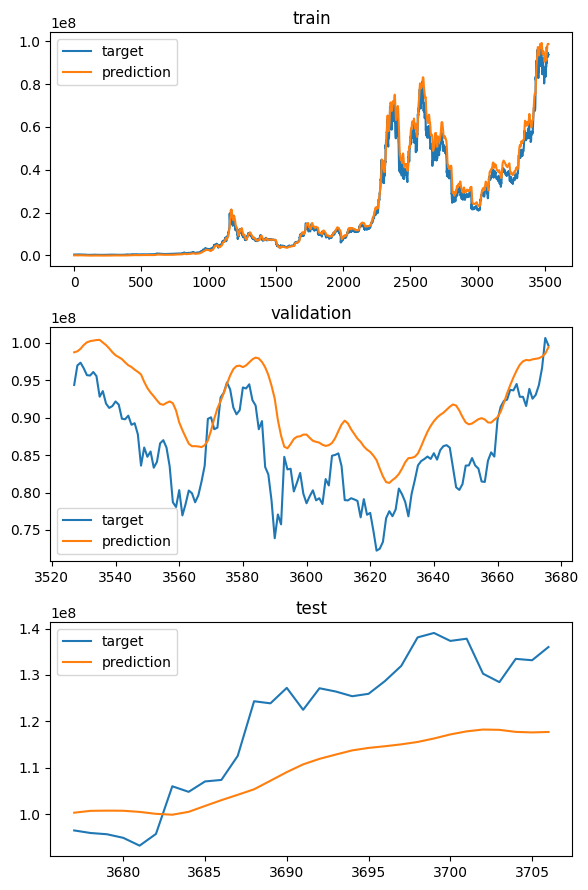

In [100]:
import wandb

# wandb 초기화
wandb.init(
    project="lstm_regression_btc_krw",
    notes="Testing wandb integration",
    tags=["LSTM", "regression", "test"],
    config={
        "epochs": 100,
        "batch_size": 32,
        "learning_rate": 1e-3,
        "weight_decay": 0.01,
    },
    mode="online"  # 온라인 모드로 설정
)

# 테스트 함수 수정
def test(test_model):
    _, _, test_data_loader = get_btc_krw_data()
    test_model.eval()
    y_normalizer = 1.0e7
    total_loss = 0

    print("[TEST DATA]")
    with torch.no_grad():
        for test_batch in test_data_loader:
            input_test, target_test = test_batch
            output_test = test_model(input_test)

        for idx, (output, target) in enumerate(zip(output_test, target_test)):
            loss = abs(output.squeeze(dim=-1).item() - target.item()) * y_normalizer
            total_loss += loss
            print(
                "{0:2}: {1:6,.2f} <--> {2:6,.2f} (Loss: {3:>13,.2f})".format(
                    idx,
                    output.item() * y_normalizer,
                    target.item() * y_normalizer,
                    loss,
                )
            )

    # wandb에 테스트 결과 로깅
    wandb.log({"test_loss": total_loss / len(test_data_loader)})
    print(f"Average Test Loss: {total_loss / len(test_data_loader):.2f}")

# 전체 데이터셋 예측 및 wandb 로깅 추가
def predict_all(test_model):
    y_normalizer = 1.0e7

    X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date = get_cryptocurrency_data(
        sequence_size=21, validation_size=150, test_size=30, target_column="Close", y_normalizer=y_normalizer, is_regression=True
    )

    dataset_list = [
        CryptoCurrencyDataset(X_train, y_train),
        CryptoCurrencyDataset(X_validation, y_validation),
        CryptoCurrencyDataset(X_test, y_test),
    ]
    dataset_labels = ["train", "validation", "test"]

    num = 0
    fig, axs = plt.subplots(3, 1, figsize=(6, 9))

    for i in range(3):
        X, TARGET_Y, PREDICTION_Y = [], [], []
        for data in dataset_list[i]:
            input, target = data
            prediction = test_model(input.unsqueeze(0)).squeeze(-1).squeeze(-1)

            X.append(num)
            TARGET_Y.append(target.item() * y_normalizer)
            PREDICTION_Y.append(prediction.item() * y_normalizer)

            num += 1

        axs[i].plot(X, TARGET_Y, label="target")
        axs[i].plot(X, PREDICTION_Y, label="prediction")
        axs[i].set_title(dataset_labels[i])
        axs[i].legend()

        # wandb에 예측 데이터 로깅
        wandb.log({
            f"{dataset_labels[i]}_target": TARGET_Y,
            f"{dataset_labels[i]}_prediction": PREDICTION_Y
        })

    plt.tight_layout()
    plt.show()

# 메인 함수
def main(args):
    run_time_str = datetime.now().astimezone().strftime("%Y-%m-%d_%H-%M-%S")

    config = {
        "epochs": args.epochs,
        "batch_size": args.batch_size,
        "validation_intervals": args.validation_intervals,
        "learning_rate": args.learning_rate,
        "early_stop_patience": args.early_stop_patience,
        "early_stop_delta": args.early_stop_delta,
        "weight_decay": args.weight_decay,
    }

    wandb.init(
        mode="online",
        project="lstm_regression_btc_krw",
        notes="btc_krw regression with updated hyperparameters",
        tags=["lstm", "regression", "tuning"],
        name=run_time_str,
        config=config,
    )

    test_model = get_model()
    latest_file_path = os.path.join(CHECKPOINT_FILE_PATH, "lstm_regression_btc_krw_checkpoint_latest.pt")
    print(f"MODEL FILE: {latest_file_path}")

    try:
        test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device("cpu")))
        print(f"Loaded model checkpoint from {latest_file_path}")
    except FileNotFoundError:
        print(f"Checkpoint not found at {latest_file_path}. Running with untrained model.")

    test(test_model)
    predict_all(test_model)

if __name__ == "__main__":
    import sys

    # Jupyter 환경에서 명령줄 인자 제거
    sys.argv = ['']  # Jupyter의 추가 인자를 제거

    parser = get_parser()
    args = parser.parse_args()
    main(args)


## classification

In [ ]:
wandb.login(relogin=True)

In [103]:
def get_btc_krw_data(sequence_size=10, validation_size=100, test_size=10, is_regression=True):
    X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date = get_cryptocurrency_data(
        sequence_size=sequence_size, validation_size=validation_size, test_size=test_size,
        target_column='Close', y_normalizer=1.0e7, is_regression=is_regression
    )

    # Dataset 및 DataLoader 생성
    train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
    validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
    test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

    train_data_loader = DataLoader(
        dataset=train_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
    )
    validation_data_loader = DataLoader(
        dataset=validation_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
    )
    test_data_loader = DataLoader(
        dataset=test_crypto_currency_dataset, batch_size=len(test_crypto_currency_dataset), shuffle=True
    )

    return train_data_loader, validation_data_loader, test_data_loader

In [106]:
import torch
import torch.nn as nn
import torch.optim as optim
from datetime import datetime
import os
import wandb

# 디렉토리 설정
BASE_PATH = os.getcwd()  # 현재 작업 디렉토리
CHECKPOINT_FILE_PATH = os.path.join(BASE_PATH, "checkpoints")  # 체크포인트 파일 저장 경로
os.makedirs(CHECKPOINT_FILE_PATH, exist_ok=True)  # 디렉토리가 없으면 생성

# 분류 작업을 위한 LSTM 모델 정의
class ClassificationLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(ClassificationLSTM, self).__init__()
        # LSTM 계층 정의
        self.lstm = nn.LSTM(
            input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,
            batch_first=True, dropout=dropout
        )
        # 완전 연결 계층 정의
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # LSTM 계층에서 출력
        x, _ = self.lstm(x)
        # 마지막 타임스텝의 출력 사용
        x = self.fc(x[:, -1, :])
        return x

# 모델 학습 함수
def train_model(model, train_loader, val_loader, config, criterion, device):
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])  # Adam 옵티마이저
    best_val_loss = float('inf')  # 최적의 검증 손실 초기값 설정
    patience_counter = 0  # Early stopping 카운터

    for epoch in range(config['epochs']):
        model.train()  # 모델을 학습 모드로 설정
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        # 학습 데이터에 대해 손실 계산 및 가중치 업데이트
        # 학습 데이터에 대해 손실 계산 및 가중치 업데이트
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
        
            # 타겟 데이터를 정수형으로 변환
            targets = targets.long()
            assert torch.all((targets >= 0) & (targets < 2)), "Target values must be in the range [0, num_classes - 1]"
        
            optimizer.zero_grad()  # 그래디언트 초기화
            outputs = model(inputs)  # 모델 예측
        
            # 출력 크기와 타겟 크기 확인
            print(f"Outputs shape: {outputs.shape}, Targets shape: {targets.shape}")
            assert outputs.shape[1] == 2, "Model output size must match the number of classes"
        
            loss = criterion(outputs, targets)  # 손실 계산
            loss.backward()  # 역전파
            optimizer.step()  # 가중치 업데이트


            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)  # 가장 높은 확률을 가진 클래스 예측
            train_total += targets.size(0)  # 전체 샘플 수
            train_correct += (predicted == targets).sum().item()  # 정확히 예측한 샘플 수

        train_accuracy = train_correct / train_total  # 학습 정확도 계산
        train_loss /= len(train_loader)  # 평균 학습 손실 계산

        # 검증 데이터에 대한 평가
        model.eval()  # 모델을 평가 모드로 설정
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += targets.size(0)
                val_correct += (predicted == targets).sum().item()

        val_accuracy = val_correct / val_total  # 검증 정확도 계산
        val_loss /= len(val_loader)  # 평균 검증 손실 계산

        # 학습 및 검증 결과 출력
        print(f"Epoch {epoch + 1}/{config['epochs']} | "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

        # Early stopping 로직
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # 모델 저장
            torch.save(model.state_dict(), os.path.join(CHECKPOINT_FILE_PATH, f"best_model.pt"))
        else:
            patience_counter += 1
            if patience_counter >= config['early_stop_patience']:
                print("Early stopping triggered.")
                break

# 메인 함수
def main():
    # WandB 초기화
    wandb.init(project="classification_lstm", config={
        'epochs': 50,  # 학습 에포크 수
        'batch_size': 32,  # 배치 크기
        'learning_rate': 1e-3,  # 학습률
        'weight_decay': 1e-4,  # 가중치 감쇠
        'dropout': 0.3,  # 드롭아웃 비율
        'early_stop_patience': 5,  # Early stopping patience
    })
    config = wandb.config

    # 디바이스 설정 (CUDA 사용 가능 여부 확인)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 데이터 로더 설정 (예: `get_btc_krw_data` 함수가 데이터셋 반환)
    train_loader, val_loader, test_loader = get_btc_krw_data()

    # 모델 초기화
    model = ClassificationLSTM(input_size=5, hidden_size=128, num_layers=2, output_size=2, dropout=config['dropout'])
    model.to(device)  # 모델을 디바이스로 이동

    # 손실 함수 설정 (분류 작업에 CrossEntropyLoss 사용)
    criterion = nn.CrossEntropyLoss()

    # 모델 학습
    train_model(model, train_loader, val_loader, config, criterion, device)

    # 테스트 데이터 평가
    model.load_state_dict(torch.load(os.path.join(CHECKPOINT_FILE_PATH, "best_model.pt")))  # 저장된 모델 불러오기
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            test_total += targets.size(0)
            test_correct += (predicted == targets).sum().item()

    test_accuracy = test_correct / test_total  # 테스트 정확도 계산
    print(f"Test Accuracy: {test_accuracy:.4f}")  # 테스트 결과 출력

if __name__ == "__main__":
    main()


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


# 과제3

# 숙제 후기

# 기술적으로 얻은 점